<a href="https://colab.research.google.com/github/descandon88/Analisis-de-Redes/blob/proyecto/P_7_RCA_Espacio_Productos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajo Final de Análisis de Redes 2021: RCAs, Proximidades y Espacio de Productos
=====================================================================================

###Librerías

In [83]:

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
# Librerías para visualizacion
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import re
import networkx as nx
from itertools import count
from itertools import combinations
from itertools import product
import statsmodels.api as sm
import urllib.request, json
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
import seaborn as sns
sns.set_style('whitegrid') # grids en dark background

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('librerías cargadas')

librerías cargadas


## Se importa la base preparada desde Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
## Importamos la base ya preparada desde drive
df = pd.read_csv("/content/drive/MyDrive/eci/base/df_updated.csv")
print('dataframe cargado')

## Exploración del Data Frame

#### Estructura de la base

In [4]:
df.sample(n=6)

,year,country_code,country_name,product_code,product_name,export_value
313548,2015,AZE,Azerbaijan,706,"Carrots, turnips, salad beetroot, salsify, celeriac, radishes and similar edible roots; fresh or chilled",344462
2034284,2001,AIA,Anguilla,2925,Carboxyimide-function compounds (including saccharin and its salts) and imine-function compounds,0
675810,2019,TKM,Turkmenistan,1211,"Plants and parts of plants (including seeds and fruits), used primarily in perfumery, pharmacy; for insecticidal, fungicidal or similar purposes, fresh or dried, whether or not crushed or powdered",2103911
5470584,2004,BRN,Brunei Darussalam,7906,"Zinc; tubes, pipes and tube or pipe fittings (eg couplings, elbows, sleeves)",1262
5437539,2013,MNP,Northern Mariana Islands,7806,Lead; articles n.e.s. in chapter 78,0
3822330,2005,LVA,Latvia,5601,"Wadding of textile materials and articles thereof; textile fibres, not exceeding 5 mm in length (flock), textile dust and mill neps",188289


#### Agrego un leading zero al product_code de la base para cumplir con la nomenclatura del HS

In [5]:
df['product_code']  = df['product_code'].apply(lambda x: '{0:0>4}'.format(x))


In [6]:
df.head()

,year,country_code,country_name,product_code,product_name,export_value
0,1995,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",18008
1,1996,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",0
2,1997,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",0
3,1998,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",0
4,1999,ABW,Aruba,0101,"Horses, asses, mules and hinnies; live",14473


#### ¿Cuántos años existen en la base? 

In [7]:
df['year'].unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

#### Cuántos productos contiene la base?

In [8]:
df['product_name'].nunique()


1242

#### Ejercicio: ¿Cuáles fueron los productos de mayor exportación de Uruguay en el 2019 ? 


In [9]:
# Creo un dataframe temporal (tmp_y) solo para Uruguay en el año 2019
df_tmp_uy = df[ (df['country_code']=='URY') & (df['year'] == 2019) ].copy()
# Creo un dataframe 'df_uy' que contenga la suma de las exportaciones por producto 
df_uy = df_tmp_uy.groupby(['product_code','product_name'],as_index=False)['export_value'].sum()
# Ordeno la base df_uy
df_uy.sort_values(by=['export_value'],ascending=False,inplace=True)
# show first 10 rows
df_uy[0:15]

,product_code,product_name,export_value
101,1201,Soya beans; whether or not broken,1359592960
530,4703,"Chemical wood pulp, soda or sulphate, other than dissolving grades",1304880128
7,0202,Meat of bovine animals; frozen,1181618176
503,4403,"Wood in the rough, whether or not stripped of bark or sapwood, or roughly squared",706908224
24,0402,Milk and cream; concentrated or containing added sugar or other sweetening matter,431324608
89,1006,Rice,331513728
98,1107,Malt; whether or not roasted,293003072
6,0201,Meat of bovine animals; fresh or chilled,267780832
1,0102,Bovine animals; live,180433152
1217,9999,Commodities not specified according to kind,169718416


#### ¿Cómo fué la exportación de productos "Meat of bovine animals; frozen" de Uruguay durante todos los años de la base? 

<Figure size 576x576 with 0 Axes>

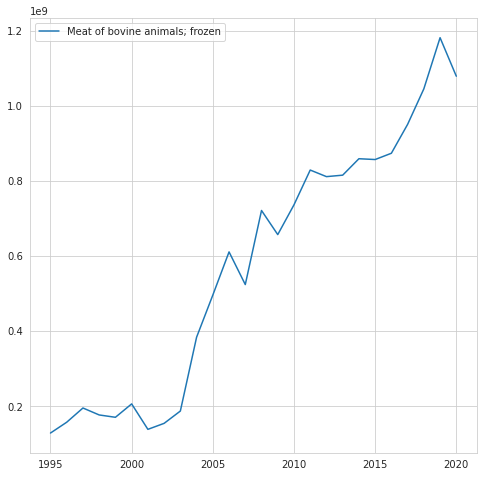

In [10]:
daf_uy = df[ (df['country_code']=='URY')].copy()
#df3 = df2[df2['product_name']=='Cars']
df1_uy = daf_uy[daf_uy['product_code']=='0202']
plt.figure(figsize=(8,8))

plt.plot("year", "export_value", data=df1_uy, label = "Meat of bovine animals; frozen")

plt.legend()
plt.show()

#### **¿Cómo fueron los comportamientos de los Top 5 de productos de exportación de Uruguay durante todos los años de la base?**

<Figure size 864x864 with 0 Axes>

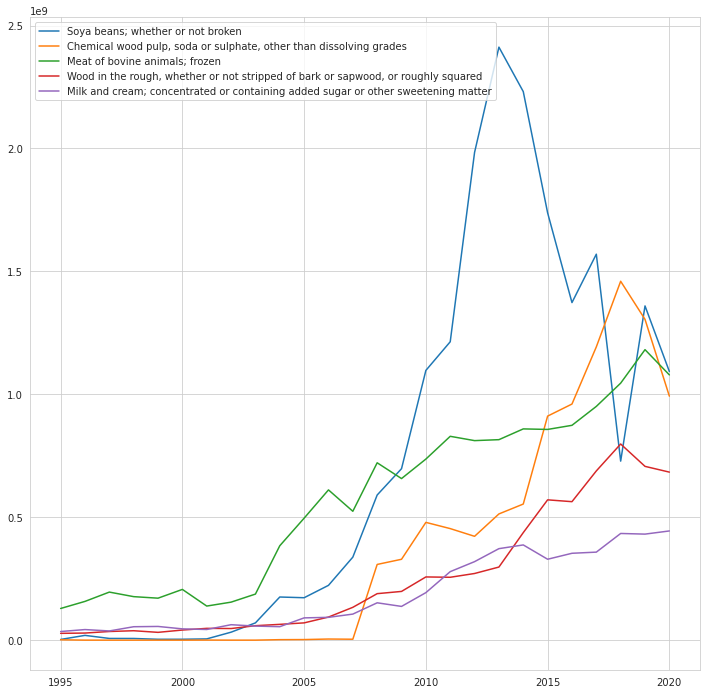

In [11]:
daf_uy = df[ (df['country_code']=='URY')].copy()
#df3 = df2[df2['product_name']=='Cars']

df1_uy = daf_uy[daf_uy['product_code']=='1201']
df2_uy = daf_uy[daf_uy['product_code']=='4703']
df3_uy = daf_uy[daf_uy['product_code']=='0202']
df4_uy = daf_uy[daf_uy['product_code']=='4403']
df5_uy = daf_uy[daf_uy['product_code']=='0402']
#df5_uy = daf_uy[daf_uy['product_code']=='travel']
#df6_uy = daf_uy[daf_uy['product_code']=='1006'] --> refiere a Rice


plt.figure(figsize=(12,12))

plt.plot("year", "export_value", data=df1_uy, label="Soya beans; whether or not broken")
plt.plot("year", "export_value", data=df2_uy, label = "Chemical wood pulp, soda or sulphate, other than dissolving grades")
plt.plot("year", "export_value", data=df3_uy, label = "Meat of bovine animals; frozen")
#plt.plot("year", "export_value", data=df4_uy, label = "Travel and tourism	")
plt.plot("year", "export_value", data=df4_uy, label = "Wood in the rough, whether or not stripped of bark or sapwood, or roughly squared")
plt.plot("year", "export_value", data=df5_uy, label="Milk and cream; concentrated or containing added sugar or other sweetening matter")


plt.legend()
plt.show()


#### **¿y medicamentos ?**

<Figure size 864x864 with 0 Axes>

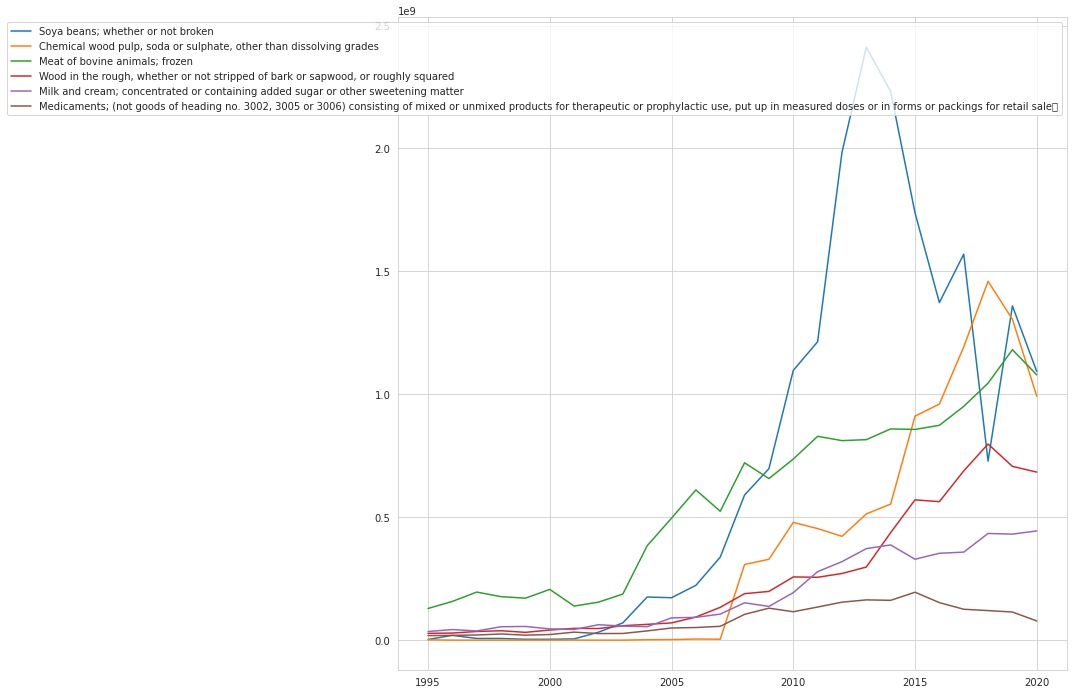

In [12]:
daf_uy = df[ (df['country_code']=='URY')].copy()
#df3 = df2[df2['product_name']=='Cars']

df1_uy = daf_uy[daf_uy['product_code']=='1201']
df2_uy = daf_uy[daf_uy['product_code']=='4703']
df3_uy = daf_uy[daf_uy['product_code']=='0202']
df4_uy = daf_uy[daf_uy['product_code']=='4403']
df5_uy = daf_uy[daf_uy['product_code']=='0402']
df6_uy = daf_uy[daf_uy['product_code']=='3004']
#df7_uy = daf_uy[daf_uy['product_code']=='1006'] --> refiere a Rice


plt.figure(figsize=(12,12))

plt.plot("year", "export_value", data=df1_uy, label="Soya beans; whether or not broken")
plt.plot("year", "export_value", data=df2_uy, label = "Chemical wood pulp, soda or sulphate, other than dissolving grades")
plt.plot("year", "export_value", data=df3_uy, label = "Meat of bovine animals; frozen")
plt.plot("year", "export_value", data=df4_uy, label = "Wood in the rough, whether or not stripped of bark or sapwood, or roughly squared")
plt.plot("year", "export_value", data=df5_uy, label="Milk and cream; concentrated or containing added sugar or other sweetening matter")
plt.plot("year", "export_value", data=df6_uy, label = "Medicaments; (not goods of heading no. 3002, 3005 or 3006) consisting of mixed or unmixed products for therapeutic or prophylactic use, put up in measured doses or in forms or packings for retail sale	")



plt.legend()
plt.show()


##**Ventaja Comparativa Revelada (RCA)**

###¿En qué productos están especializados los países? Tomando como referencia a Hidalgo et al. (2007), se calcula la Ventaja Comparativa Revelada (RCA) de cada par país-producto. Es decir, ¿cuánto un país "sobreexporta" un producto en comparación con todos los demás países? 

###Técnicamente, este es el índice de ventaja comparativa de Balassa, calculado de la siguiente manera para el producto py el país c en el momento t:

##RCAcpt=Xcpt/XctXpt/Xt(1)

###donde Xcpt representa el valor total de las exportaciones del producto "p" del país "c" en el tiempo "t" entre todos los importadores. Un subíndice omitido indica una suma sobre la dimensión omitida, por ejemplo: Xt = ∑c, p, tXcpt.

### Un par producto-país con RCA> 1 significa que el producto está sobrerrepresentado en la canasta de exportación del país.

###Usamos el conjunto de datos comerciales original ("df") que se encuentra ya cargado:

In [17]:
## Función para el cálcula de RCA

def calc_rca(data,pais_col,prod_col,anio_col,value_col):
    """
      La función que calcula la RCA
    
    """
    print('Creando las combinaciones de país-producto-tiempo')
    df_all = pd.DataFrame(list(product(data[anio_col].unique(), data[pais_col].unique(),data[prod_col].unique())))
    df_all.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,value_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # En esta parte se calculan propiedades
    print('calculando')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([pais_col, anio_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([prod_col, anio_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([anio_col])[value_col].transform('sum')

    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt']) #--> ecuación de las ventaja comparativa revelada RCA
    
    ## 0 si el producto / país tiene 0 exportaciones
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0 
    # drop the properties 
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all



In [18]:
df_rca = calc_rca(data=df,pais_col='country_name',prod_col='product_name',anio_col='year',value_col='export_value')

print('rca listo!!')

# show results
df_rca[0:10]

Creando las combinaciones de país-producto-tiempo
Se procede a fusionar los datos
calculando
rca listo


,year,country_name,product_name,export_value,RCAcpt
0,1995,Aruba,"Horses, asses, mules and hinnies; live",18008.00,0.13
1,1995,Aruba,Bovine animals; live,0.00,0.00
2,1995,Aruba,Swine; live,0.00,0.00
3,1995,Aruba,Sheep and goats; live,0.00,0.00
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",0.00,0.00
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",2336.00,0.05
6,1995,Aruba,Meat of bovine animals; fresh or chilled,0.00,0.00
7,1995,Aruba,Meat of bovine animals; frozen,0.00,0.00
8,1995,Aruba,"Meat of swine; fresh, chilled or frozen",0.00,0.00
9,1995,Aruba,"Meat of sheep or goats; fresh, chilled or frozen",0.00,0.00


###**¿Qué productos se especializó Noruega, Uruguay y Nueva Zelanda en el 2019?** 

In [40]:
# Noruega
print("\n Norway: \n")

df_rca[ (df_rca['year']==2019) & (df_rca['country_name']=='Norway')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:5]

print("\n Uruguay:\n")

# Uruguay
df_rca[ (df_rca['year']==2019) & (df_rca['country_name']=='Uruguay')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:10]

print("\n New Zealand:\n")

# Nueva Zelanda
df_rca[ (df_rca['year']==2019) & (df_rca['country_name']=='New Zealand')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:10]


 Norway: 



,product_name,RCAcpt,year
7396127,Fish; fresh or chilled (excluding fish fillets and other fish meat of heading no. 0304),63.21,2019
7396534,"Residual lyes from the manufacture of wood pulp, whether or not concentrated, desugared or chemically treated, including lignin sulphonates, but excluding tall oil of heading no. 3803",43.55,2019
7396452,Carboxyamide-function compounds; amide-function compounds of carbonic acid,28.14,2019
7396130,"Fish; dried, salted or in brine, smoked fish, whether or not cooked before or during the smoking process, fish meal fit for human consumption",25.18,2019
7397247,"Vessels; other, including warships and lifeboats, other than rowing boats",19.65,2019



 Uruguay:



,product_name,RCAcpt,year
7465762,Malt; whether or not roasted,147.98,2019
7466249,Wool and fine or coarse animal hair; carded or combed (including combed wool in fragments),104.06,2019
7465672,"Meat of horses, asses, mules or hinnies; fresh, chilled or frozen",91.80,2019
7466172,"Wood in the rough, whether or not stripped of bark or sapwood, or roughly squared",88.74,2019
7465669,Meat of bovine animals; frozen,88.22,2019
7466199,"Chemical wood pulp, soda or sulphate, other than dissolving grades",75.82,2019
7466247,"Waste of wool or of fine or coarse animal hair, including yarn waste but excluding garnetted stock",72.41,2019
7465786,"Fats of bovine animals, sheep or goats; raw or rendered, whether or not pressed or solvent-extracted",51.05,2019
7465765,Soya beans; whether or not broken,48.38,2019
7466245,"Wool, not carded or combed",47.30,2019



 New Zealand:



,product_name,RCAcpt,year
7399845,"Meat of sheep or goats; fresh, chilled or frozen",155.94,2019
7400371,"Wood pulp, mechanical wood pulp",153.59,2019
7400237,"Casein, caseinates and other casein derivatives; casein glues",138.75,2019
7399860,Milk and cream; concentrated or containing added sugar or other sweetening matter,127.45,2019
7399875,"Ivory, tortoise-shell, whalebone and whalebone hair, horns, antlers, hooves, nails, claws and beaks unworked or simply prepared, not cut to shape; waste and powder of these products",117.01,2019
7399863,Butter and other fats and oils derived from milk,104.59,2019
7400346,"Wood in the rough, whether or not stripped of bark or sapwood, or roughly squared",68.26,2019
7399849,"Meat and edible meat offal, n.e.s. in chapter 2; fresh, chilled or frozen",68.15,2019
7399983,"Extracts and juices of meat, fish or crustaceans, molluscs or other aquatic invertebrates",56.10,2019
7399867,Honey; natural,55.36,2019


##**CALCULO DE PROXIMIDADES ENTRE PRODUCTOS**

###Teniendo los RCA para cada país, pasamos hacer el cálculo de proximidades entre productos. 
###Tomando como referencia el documento de Hidalgo (2007):

![](https://drive.google.com/uc?export=view&id=1X28TNOgSLwReetxgk569vcu26TANkm4V
)






### La medición de similitud entre productos i y j basado en la probabilidad condicional de tener RCA, que mide si un país es un exportador efectivo (RCA>1) de  un bien i o no (RCA<1). 
###Se crea el umbral Mcp que refiere a una nueva columna de tipo binaria donde asigna 0 cuando RCA<1 y 1 cuando RCA>1



In [34]:

df_rca['Mcp'] = 0
df_rca.loc[df_rca['RCAcpt']>1,'Mcp'] = 1

In [35]:
df_rca.sort_values(by=['year','RCAcpt'], ascending=False)

,year,country_name,product_name,export_value,RCAcpt,Mcp
7518739,2020,Anguilla,"Lead; plates, sheets, strip and foil, lead powders and flakes",2146256.00,20973.04,1
7568830,2020,Comoros,"Cloves; (whole fruit, cloves and stems)",17140862.00,16496.34,1
7717340,2020,French Polynesia,"Pearls; natural or cultured, whether or not worked or graded but not strung, mounted or set; ungraded pearls, natural or cultured, temporarily strung for convenience of transport",24010362.00,14899.72,1
7756330,2020,Tonga,"Coral and similar materials, unworked or simply prepared, shells of molluscs, crustaceans or echinoderms and cuttle-bone, not cut to shape powder and waste thereof",809310.00,11043.86,1
7710233,2020,Palau,Vessels and other floating structures; for breaking up,7225117.00,10304.04,1
...,...,...,...,...,...,...
300559,1995,Saint Barthélemy,"Sculptures and statuary; original, in any material",0.00,0.00,0
300560,1995,Saint Barthélemy,"Stamps, postage or revenue; stamp-postmarks, first-day covers, postal stationery (stamped paper) and like, used, or if unused not of current or new issue in the country to which they are destined",0.00,0.00,0
300561,1995,Saint Barthélemy,"Collections and collectors' pieces; of zoological, botanical, mineralogical, anatomical, historical, archaeological, palaeontological, ethnographic or numismatic interest",0.00,0.00,0
300562,1995,Saint Barthélemy,Antiques; of an age exceeding one hundred years,0.00,0.00,0


###A continuación, se procede a calcular la frecuencia con la que dos productos están presentes en los mismos países, utilizando el umbral de Mcp:

\begin{equation} 
C_{pp'} = \sum \limits_{c} M_{cp} M_{cp'}
\tag{1}
\end{equation}

###Para obtener un valor exacto de la proximidad del producto, se requiere corregir estos números en función de la medida en que los productos están presentes en general en los flujos comerciales entre países. Para ello, Hidalgo et al. (2007), calculan la proximidad del producto de la siguiente manera, definiéndola como el mínimo de dos probabilidades condicionales:

\begin{equation}
C_{ppt'}  = \min \left( \frac{C_{pp'}}{C_{p}},\frac{C_{pp'}}{C_{p'}} \right)
\tag{2}
\end{equation}

###Finalmente, la proximidad entre dos productos i y j se define como el mínimo de la probabilidad condicional de tener ventaja comparativa en uno de los dos, dado que se exporta el otro bien.Es decir,


![](https://drive.google.com/uc?export=view&id=1jzeSlcQbEqRZFXbRBIV78Jv89A8WcoSV
) 


In [84]:
def calc_cppt(data,country_col,product_col):
    """
    Función para el cálcula de las co-ocurrencias en los países
    Retorna:
        Dataframe con valores de co-ocurrencias para cada par de producto
    """

    # Se crea combinaciones dentro del country_col (i.e. paises) por productos (i.e. products)
    dft = (data.groupby(country_col)[product_col].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
            .reset_index(level=1, drop=True)
            .reset_index())
    dft.rename(columns={0:f'{product_col}_1'}, inplace=True)
    dft.rename(columns={1:f'{product_col}_2'}, inplace=True)

    # -- {product_col} 1 X {product_col} 2 == {product_col} 2 X {product_col} 1
    dft2 = dft.copy()
    dft2.rename(columns={f'{product_col}_1':f'{product_col}_2t'}, inplace=True)
    dft2.rename(columns={f'{product_col}_2':f'{product_col}_1'}, inplace=True)
    dft2.rename(columns={f'{product_col}_2t':f'{product_col}_2'}, inplace=True)
    # -- add second half
    dft3 = pd.concat([dft,dft2],axis=0,sort=False)

    # retiro de diagonales en caso de que estén presentes
    dft3 = dft3[ dft3[f'{product_col}_1'] != dft3[f'{product_col}_2'] ]

    # se calcula la cantindad N veces que los {product_col}s ocurren simultáneamente
    dft3['count'] = 1
    dft3 = dft3.groupby([f'{product_col}_1',f'{product_col}_2'],as_index=False)['count'].sum()
    dft3.rename(columns={f'count':f'Cpp'}, inplace=True)

    # Calculo de Ubicuidad
    df_ub = data.groupby(product_col,as_index=False)['Mcp'].sum()

    # merge del calculo de ubicuidad en la matriz de cpp 
    df_ub.rename(columns={f'{product_col}':f'{product_col}_1'}, inplace=True)
    dft3 = pd.merge(dft3,df_ub,how='left',on=f'{product_col}_1')

    df_ub.rename(columns={f'{product_col}_1':f'{product_col}_2'}, inplace=True)
    dft3 = pd.merge(dft3,df_ub,how='left',on=f'{product_col}_2')

    # Toma el min de probabilidades condicionales
    dft3['kpi'] = dft3['Cpp']/dft3['Mcp_x']
    dft3['kpj'] = dft3['Cpp']/dft3['Mcp_y']
    dft3['phi'] = dft3['kpi']
    dft3.loc[dft3['kpj']<dft3['kpi'],'phi'] = dft3['kpj']
    
    return dft3



In [85]:

# Filtro la base para el año 2019
dft = df_rca[df_rca['year']==2019].copy()

# Se mantienen las combinaciones de país-producto donde Mcp == 1 ( RCAcp> 1)
dft = dft[dft['Mcp']==1]

# Se calcula cpp con la función df_cppt
df_cppt = calc_cppt(dft,country_col='country_name',product_col='product_name')

print('dataframe de productos co-ocurrentes y aproximados se encuentra listo')

dataframe de productos co-ocurrentes y aproximados se encuentra listo


####Productos que co-ocurren más amenudo

In [81]:

## Se ordena el dataframe de acuerdo a los valores de Cpp
df_cppt.sort_values(by=['Cpp'],ascending=False)[0:10]

,product_name_1,product_name_2,Cpp,Mcp_x,Mcp_y,kpi,kpj,phi
53711,Aluminium; waste and scrap,Copper; waste and scrap,81,108,112,0.75,0.72,0.72
313981,Copper; waste and scrap,Aluminium; waste and scrap,81,112,108,0.72,0.75,0.72
53797,Aluminium; waste and scrap,Ferrous waste and scrap; remelting scrap ingots of iron or steel,78,108,104,0.72,0.75,0.72
413369,Ferrous waste and scrap; remelting scrap ingots of iron or steel,Aluminium; waste and scrap,78,104,108,0.75,0.72,0.72
314292,Copper; waste and scrap,Ferrous waste and scrap; remelting scrap ingots of iron or steel,74,112,104,0.66,0.71,0.66
413595,Ferrous waste and scrap; remelting scrap ingots of iron or steel,Copper; waste and scrap,74,104,112,0.71,0.66,0.66
315072,Copper; waste and scrap,"Waste, parings and scrap, of plastics",55,112,76,0.49,0.72,0.49
1316427,"Waste, parings and scrap, of plastics",Copper; waste and scrap,55,76,112,0.72,0.49,0.49
414460,Ferrous waste and scrap; remelting scrap ingots of iron or steel,"Waste, parings and scrap, of plastics",51,104,76,0.49,0.67,0.49
314731,Copper; waste and scrap,"Plastic articles for the conveyance or packing of goods; stoppers, lids, caps and other closures of plastics",51,112,65,0.46,0.78,0.46


### Los productos más próximos

In [82]:
## Se ordena el dataframe de acuerdo a los valores de phi que refiere al min de probabilidades condicionales

df_cppt.sort_values(by=['phi'],ascending=False)[0:10]

,product_name_1,product_name_2,Cpp,Mcp_x,Mcp_y,kpi,kpj,phi
134171,"Blouses, shirts and shirt-blouses; women's or girls', knitted or crocheted","Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (not swimwear), women's or girls', knitted or crocheted",41,48,46,0.85,0.89,0.85
1125956,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (not swimwear), women's or girls', knitted or crocheted","Blouses, shirts and shirt-blouses; women's or girls', knitted or crocheted",41,46,48,0.89,0.85,0.85
1128003,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)","Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (not swimwear), women's or girls', knitted or crocheted",40,47,46,0.85,0.87,0.85
1126800,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (not swimwear), women's or girls', knitted or crocheted","Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)",40,46,47,0.87,0.85,0.85
1125546,"Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches, shorts (not swimwear); men's or boys', knitted or crocheted","Shirts; men's or boys', knitted or crocheted",38,45,44,0.84,0.86,0.84
1058851,"Shirts; men's or boys', knitted or crocheted","Suits, ensembles, jackets, blazers, trousers, bib and brace overalls, breeches, shorts (not swimwear); men's or boys', knitted or crocheted",38,44,45,0.86,0.84,0.84
1127153,"Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)","Blouses, shirts and shirt-blouses; women's or girls', knitted or crocheted",39,47,48,0.83,0.81,0.81
134172,"Blouses, shirts and shirt-blouses; women's or girls', knitted or crocheted","Suits, ensembles, jackets, dresses, skirts, divided skirts, trousers, bib and brace overalls, breeches and shorts (other than swimwear); women's or girls' (not knitted or crocheted)",39,48,47,0.81,0.83,0.81
111260,Barley,Wheat and meslin,17,21,20,0.81,0.85,0.81
1327724,Wheat and meslin,Barley,17,20,21,0.85,0.81,0.81


###**¿Qué producto está más relacionado al producto:"Meat of horses, asses, mules or hinnies; fresh, chilled or frozen"**

In [86]:
PRODUCT = 'Meat of horses, asses, mules or hinnies; fresh, chilled or frozen'
# select only this product
dft = df_cppt[df_cppt['product_name_1']==PRODUCT].copy()
# sort from high to low on phi
dft.sort_values(by=['phi'],ascending=False,inplace=True)
# show only first row
dft[0:1]

,product_name_1,product_name_2,Cpp,Mcp_x,Mcp_y,kpi,kpj,phi
731681,"Meat of horses, asses, mules or hinnies; fresh, chilled or frozen",Rape or colza seeds; whether or not broken,12,24,22,0.50,0.55,0.50


##**ESPACIO DE PRODUCTOS**

## The Product Space Conditions the Development of Nations (C. A. HIDALGO, B.KLINGERA.-L. BARABÁSIAND R. HAUSMANN)

### Para la construcción del gráfico del Espacio de Productos, la matriz de proximidad se simplifica, extrayendo aquellas conexiones más importantes y que permiten mantener todos los nodos del grafo conectados, utilizando como en Hidalgo et al. (2007) un algoritmo de MaximumSpanningTree, y agregando a este las principales n conexiones adicionales, donde n es el número de nodos (productos).

![](https://drive.google.com/uc?export=view&id=1YuGs1Y2oNIm9nTa8W1hRtdPXKuTlZ_qZ
)




**Cada nodo es un producto:**

Para posicionarlos en el espacio del producto, Hidalgo et al. (2007) utilizaron un algoritmo MaximumSpanningTree (que coloca los nodos de tal manera que haya la menor cantidad posible de lazos cruzados, utilizando simulaciones físicas con algoritmos dirigidos por la fuerza), seguido de la elaboración a mano del resultado para separar visualmente distintos ' agrupaciones de productos.

**Tamaño de los nodos:**

El tamaño en el espacio del producto representa el $ total en el comercio mundial, pero también se pueden usar otros atributos de los nodos (por ejemplo, si los nodos son industrias, el tamaño podría ser el empleo total).

**Color de los nodos**

En el espacio de productos, el color del nodo representa los principales grupos de productos (por ejemplo, agricultura, productos químicos) siguiendo la clasificación de Leamer.